In [9]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
import matplotlib.pyplot as plt
r.status()

---------------------------------
Rebound version:     	1.0.0
Build on:            	Jun 10 2015 22:03:24
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


## Simulated data:

In [10]:
data_N = 30
data_t = np.linspace(0.1,100,data_N)+0.5*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+0.2*np.pi)+0.6*(np.random.rand(data_N)-0.5))

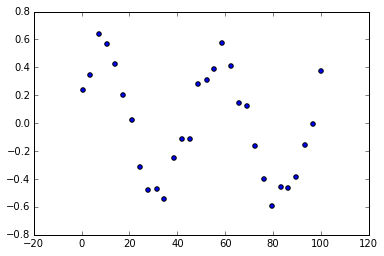

In [11]:
plt.scatter(data_t, data_rv);

## Setting up simulations

In [114]:
def simulation_rv(cart):
    r.reset()
    r.add(m=1.)
    r.add(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    ps = r.particles
    sim_rv = np.zeros(len(data_t))
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv[i] = ps[1].vx
    return sim_rv

def simulation(cart):
    r.reset()
    numvar = 4
    r.N_megnopp = numvar # 4 variation equations per particle
    r.add(m=1.)
    op = r.Particle(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    
    r.add(op)
    N = r.N
    
    r.init_megno(0.)
    ps = r.particles
    
    
    delta = 1e-8
    # First order
    for l in range(numvar):
        cart2 = cart.copy()
        cart2[l] += delta
        mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])

        vari = (N*(l+1))+1
        ps[vari].x  = ps[1].x  - mp.x
        ps[vari].y  = ps[1].y  - mp.y
        ps[vari].z  = ps[1].z  - mp.z
        ps[vari].vx = ps[1].vx - mp.vx
        ps[vari].vy = ps[1].vy - mp.vy
        ps[vari].vz = ps[1].vz - mp.vz
        
    _id = 0
    # Second order
     
    sim_rv = 0.
    sim_rvd = np.zeros((numvar,2))
    sim_rvd2 = np.zeros((numvar*(numvar+1)/2,4))
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv  += np.square(ps[1].vx-data_rv[i])
        for k in range(numvar):
            sim_rvd[k][0] += np.square(ps[1].vx+ps[(k+1)*N+1].vx-data_rv[i])
            sim_rvd[k][1] += np.square(ps[1].vx-ps[(k+1)*N+1].vx-data_rv[i])
        _id = 0
        for l in range(numvar):
            for k in range(l+1):
                sim_rvd2[_id][0] += np.square(ps[1].vx + ps[l*N+N+1].vx + ps[k*N+N+1].vx + ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                sim_rvd2[_id][1] += np.square(ps[1].vx + ps[l*N+N+1].vx - ps[k*N+N+1].vx + ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                sim_rvd2[_id][2] += np.square(ps[1].vx - ps[l*N+N+1].vx + ps[k*N+N+1].vx + ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                sim_rvd2[_id][3] += np.square(ps[1].vx - ps[l*N+N+1].vx - ps[k*N+N+1].vx + ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                _id += 1
    err  = np.sqrt(sim_rv)
    errd = np.sqrt(sim_rvd)
    errd2 = np.sqrt(sim_rvd2)
    #err = sim_rv
    #errd = sim_rvd
    #errd2 = sim_rvd2
    
    errd2m = np.zeros((numvar,numvar))
    _id = 0
    for l in range(numvar):
        for k in range(l+1):
            fdd =   (errd2[_id][0] - errd2[_id][1] - errd2[_id][2] + errd2[_id][3])
            #print fdd, err
            errd2m[l,k] = fdd
            errd2m[k,l] = fdd
            _id +=1
    
    #print err, -(errd-err)/delta, -(errd2-err)/(delta)
    
    return err, (errd[:,0]-errd[:,1])/(2.*delta), errd2m/(4.*delta*delta)

## Gradient descent to find minimum

In [115]:
gamma = 0.05
a = np.array([4.5,0.6,0.,0.]) # initial parameters
sim_rvs = []             # for plotting

lastp = 1e200
lasta = a
lastgradient = []

sim_rv0 = simulation_rv(a)

N_grid = 20
a_s = np.linspace(4.0,6.0,N_grid)

errs = []
gradients = []
hessians = []

for i,at in enumerate(a_s):
    a[0] = at
    err, gradient, hessian = simulation(a)
    # print hessian
    errs.append(err)
    gradients.append(gradient[0])
    hessians.append(hessian[0,0])
    

        

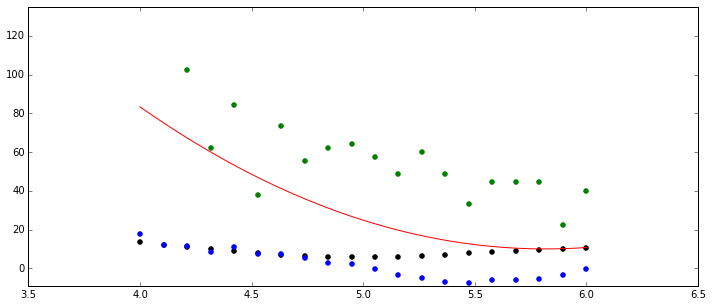

In [118]:
fig = plt.figure(figsize=(12,5))
plt.ylim([-9,135])
plt.scatter(a_s, errs, color="k");

def f(a,i):
    da = a_s[i] - a
    return errs[i] + gradients[i]*da + hessians[i]*da*da

a_s_fine = np.linspace(a_s[0],a_s[-1],N_grid*10)
err_fine = np.zeros(N_grid*10)
for i,a in enumerate(a_s_fine):
    err_fine[i] = f(a,18)
plt.plot(a_s_fine, err_fine, color="r");
plt.scatter(a_s, hessians, color="g");
plt.scatter(a_s, gradients, color="b");


NameError: name 'sim_rv1' is not defined

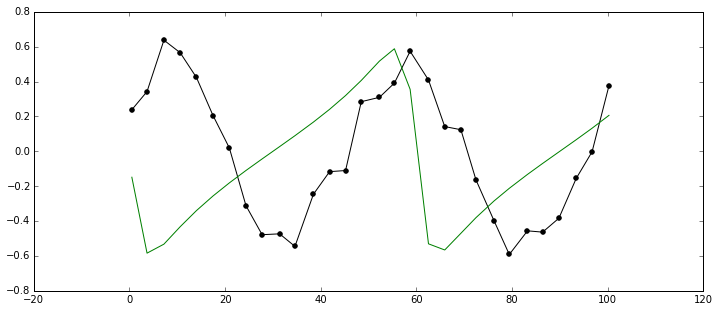

In [119]:
fig = plt.figure(figsize=(12,5))
plt.scatter(data_t, data_rv, color="k");
plt.plot(data_t, data_rv, color="k");
plt.plot(data_t, sim_rv0,color="g");
plt.plot(data_t, sim_rv1,color="r");


Black curve is data, green curve is initial guess, red curve is final "fit".

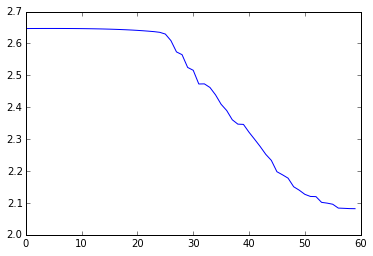

In [49]:
plt.plot(errs);